In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_24011/2033846779.py:7: DtypeWarning: Columns (36,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")


In [2]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df["therapy_length_days"] = (
        pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])
    ).dt.days

    df["day_of_week"] = pd.to_datetime(df["ActivityDateTime"]).dt.dayofweek
    df["hour"] = pd.to_datetime(df["ActivityDateTime"]).dt.hour

    df["week"] = (
        pd.to_datetime(df["ActivityDateTime"])
        - pd.to_datetime(df["ActivityDateTime"]).min()
    ).dt.days // 7

    # Select features
    df = df.drop(
        [
            "ActivityDateTime",
            "DurationInSeconds",  # total active time
            "SleepMorningDate",
            "Diagnosis",
            "CDI start date",
            "PDI start date",
            "PDI end date",
            # "Medication ",
            "Type of medication",
            "Medication start date",
            "Week",
            "Therapy session",
            "Therapy Start",
            "Therapy End",
            "Education Status",
            "Parental Status",
            "Pre.ECBI",
            "Pre.ECBI.Prob",
            "Post.ECBI",
            "Post.ECBI.Prob",
            "QuitStudy",
            "Employment Status",
            "ParticipatingParent.Sex",
            "Parent-PhoneType",
            # Data that is only available as "real time data" (more battery use?) in Companion SDK
            # NOTE: Removing these actually improves model accuracy?
            "DistanceInMeters",
            "ActiveKilocalories",
            "METmins",
            "METavg",
            "activity_seconds_sedentary",
            "activity_seconds_active",
            "activity_seconds_highly_active",
        ]
        # moving window stats
        + [
            "hr_moving_avg_15m",
            "hr_moving_std_15m",
            "hr_moving_min_15m",
            "hr_moving_max_15m",
            "hr_moving_avg_30m",
            "hr_moving_std_30m",
            "hr_moving_min_30m",
            "hr_moving_max_30m",
            "hr_moving_avg_45m",
            "hr_moving_std_45m",
            "hr_moving_min_45m",
            "hr_moving_max_45m",
        ],
        axis=1,
    )
    df = df.drop([col for col in df.columns if col.startswith("hr-prev")], axis=1)

    def yn_to_bool(df):
        """
        Convert columns with 'Y'/'N' strings to boolean True/False.
        """
        for col in df.columns:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()) == {"Y", "N"}:
                df[col] = df[col].map({"Y": True, "N": False})
        return df

    df = yn_to_bool(df)

    # Convert categorical columns to dummy variables
    df = pd.get_dummies(df, drop_first=True)

    return df


def prep_X_y(df: pd.DataFrame, response_column: str) -> tuple[pd.DataFrame, pd.Series]:
    X = df.drop(
        [
            "tantrum_within_60m",
            "tantrum_within_45m",
            "tantrum_within_30m",
            "tantrum_within_15m",
            # Useful for indexing
            "Arm_Sham",
            "dyad",
            "week",
        ],
        axis=1,
    )
    y = df[response_column].astype(int)
    return X, y

In [3]:
cleaned_dyads_df = clean_data(dyads_df)

df_train = cleaned_dyads_df[cleaned_dyads_df["Arm_Sham"]]
X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")
df_test = cleaned_dyads_df[~cleaned_dyads_df["Arm_Sham"]]
X_test, y_test = prep_X_y(df_test, "tantrum_within_60m")

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_24011/706831254.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [4]:
from sklearn.base import BaseEstimator


class HrModel(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        mean_hr = X["hr_moving_avg_60m"]
        return (mean_hr > 80) & (mean_hr < 129)

    def predict_proba(self, X):
        preds = self.predict(X)
        proba = np.zeros((len(X), 2))
        proba[:, 1] = preds.astype(float)
        proba[:, 0] = 1 - proba[:, 1]
        return proba


class PositiveModel(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return np.ones(len(X), dtype=bool)

    def predict_proba(self, X):
        proba = np.zeros((len(X), 2))
        proba[:, 1] = 1.0
        proba[:, 0] = 0.0
        return proba


class CoinFlipModel(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return self.predict_proba(X)[:, 1] >= 0

    def predict_proba(self, X):
        proba = np.zeros((len(X), 2))
        mid = len(proba) // 2
        proba[:mid, 1] = 1
        proba[mid:, 1] = -1
        proba[:, 0] = 1 - proba[:, 1]
        return proba

In [5]:
from sklearn.metrics import f1_score, precision_score, recall_score

simple_model_results = {}
for model_cls in [HrModel, PositiveModel, CoinFlipModel]:
    model = model_cls()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, zero_division=np.nan)
    precision = precision_score(y_test, y_pred, zero_division=np.nan)
    recall = recall_score(y_test, y_pred, zero_division=np.nan)

    simple_model_results[model_cls.__name__] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }
print(simple_model_results[HrModel.__name__])

{'f1': 0.005303515524455432, 'precision': 0.0026615078673691926, 'recall': 0.7238562091503268}


In [101]:
import time

from flaml import AutoML
from sklearn.metrics import log_loss
from sklearn.model_selection import TimeSeriesSplit

time_series_split = TimeSeriesSplit()
automl = AutoML()


def custom_metric(
    X_val,
    y_val,
    estimator,
    labels,
    X_train,
    y_train,
    weight_val=None,
    weight_train=None,
    *args,
):
    start = time.time()
    y_pred = estimator.predict_proba(X_val)
    pred_time = (time.time() - start) / len(X_val)
    val_loss = log_loss(y_val, y_pred, labels=labels, sample_weight=weight_val)
    y_pred = estimator.predict_proba(X_train)
    train_loss = log_loss(y_train, y_pred, labels=labels, sample_weight=weight_train)
    alpha = 0.5
    metric_to_minimize = val_loss * (1 + alpha) - alpha * train_loss
    metrics_to_log = {
        "val_loss": val_loss,
        "train_loss": train_loss,
        "pred_time": pred_time,
    }
    return metric_to_minimize, metrics_to_log


automl_settings = {
    "time_budget": 600,  # seconds
    "task": "classification",
    "metric": "log_loss",
    "estimator_list": ["xgboost", "lgbm"],
    "train_time_limit": 30,  # seconds
    "split_type": time_series_split,
    "early_stop": True,
}


automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
print("Best config:", automl.best_config)

[flaml.automl.logger: 11-06 10:41:13] {1752} INFO - task = classification
[flaml.automl.logger: 11-06 10:41:13] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 11-06 10:41:13] {1862} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 11-06 10:41:13] {1979} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm']
[flaml.automl.logger: 11-06 10:41:13] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 11-06 10:41:13] {2417} INFO - Estimated sufficient time budget=3587s. Estimated necessary time budget=4s.
[flaml.automl.logger: 11-06 10:41:13] {2466} INFO -  at 1.1s,	estimator xgboost's best error=0.0267,	best estimator xgboost's best error=0.0267
[flaml.automl.logger: 11-06 10:41:13] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-06 10:41:13] {2466} INFO -  at 1.5s,	estimator lgbm's best error=0.0267,	best estimator xgboost's best error=0.0267
[flaml.automl.logger: 11-06 10:41:13] {2282} INFO - iteration 2, curren

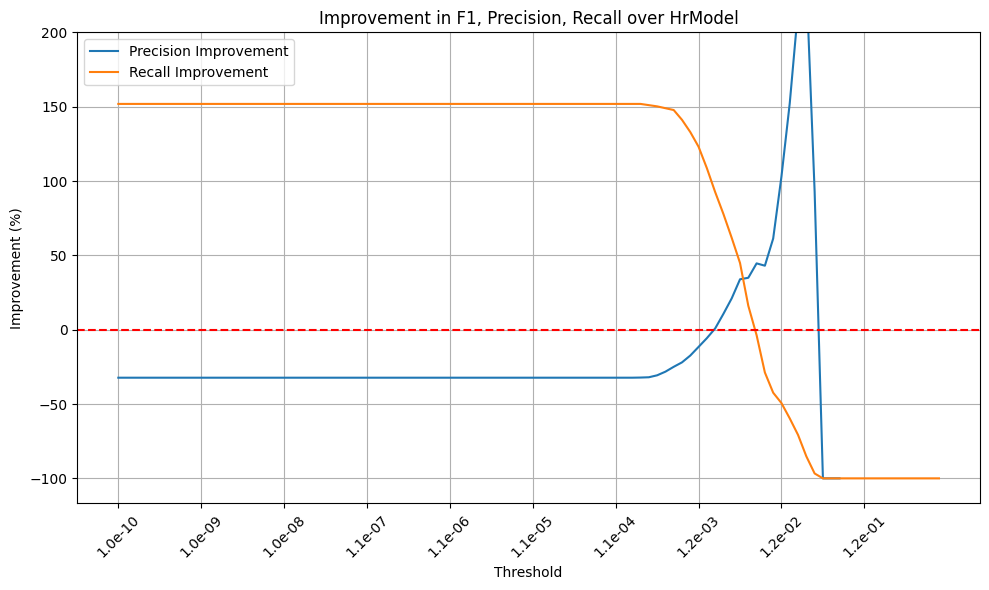

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

f1_scores = []
precisions = []
recalls = []

y_pred_proba = automl.predict_proba(X_test)
thresholds = np.logspace(-10, 0, 100)
for th in thresholds:
    y_pred = (y_pred_proba[:, 1] >= th).astype(int)
    f1_scores.append(f1_score(y_test, y_pred, zero_division=np.nan))
    precisions.append(precision_score(y_test, y_pred, zero_division=np.nan))
    recalls.append(recall_score(y_test, y_pred, zero_division=np.nan))

hr_f1 = simple_model_results["HrModel"]["f1"]
hr_precision = simple_model_results["HrModel"]["precision"]
hr_recall = simple_model_results["HrModel"]["recall"]

plt.figure(figsize=(10, 6))
plt.plot(
    thresholds,
    (np.array(precisions) - hr_precision) / hr_precision * 100,
    label="Precision Improvement",
)
plt.plot(
    thresholds,
    (np.array(recalls) - hr_recall) / hr_recall * 100,
    label="Recall Improvement",
)
plt.xscale("log")
plt.xlabel("Threshold")
plt.ylabel("Improvement (%)")
plt.title("Improvement in F1, Precision, Recall over HrModel")
plt.legend()
plt.grid(True)

plt.axhline(y=0, color="red", linestyle="--", label="y=0")
plt.xticks(thresholds[::10], [f"{t:.1e}" for t in thresholds[::10]], rotation=45)
plt.ylim(top=200)
plt.tight_layout()
plt.show()

In [98]:
threshold = 2e-3
y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
f1 = f1_score(y_test, y_pred, zero_division=np.nan)
precision = precision_score(y_test, y_pred, zero_division=np.nan)
recall = recall_score(y_test, y_pred, zero_division=np.nan)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1 Score: 0.008890332271094242
Precision: 0.00447294785645718
Recall: 0.7156862745098039


In [22]:
from collections import defaultdict
from typing import Any

import xgboost as xgb
from tqdm.auto import tqdm


def train_model(df):
    X_train, y_train = prep_X_y(df, "tantrum_within_60m")
    model = xgb.XGBClassifier(**automl.best_config)
    model.fit(X_train, y_train)
    return model


def train_and_get_dyad_models(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    base_model,
    mode: str,
    week: int,
    dyad_models: dict[str, Any],
):
    new_dyad_models = {}
    dyads = df_test["dyad"].unique()
    match mode:
        case "coin_flip_model":
            for dyad in dyads:
                new_dyad_models[dyad] = CoinFlipModel()
        case "hr_model":
            for dyad in dyads:
                new_dyad_models[dyad] = HrModel()
        case "no_retrain":
            for dyad in dyads:
                new_dyad_models[dyad] = base_model
        case "retrain_all":
            add_df = df_test[df_test["week"] < week]
            df_concat = pd.concat([df_train, add_df])
            model = train_model(df_concat)
            for dyad in dyads:
                new_dyad_models[dyad] = model
        case "retrain_dyad":
            for dyad, dyad_df in df_test.groupby("dyad"):
                add_df = dyad_df[dyad_df["week"] < week]
                df_concat = df_train.copy()
                for _ in range(len(dyads)):
                    boot_df = add_df.sample(frac=1, replace=True, random_state=None)
                    df_concat = pd.concat([df_concat, boot_df])

                model = train_model(df_concat)
                new_dyad_models[dyad] = model
        case "iter_retrain_all":
            if week == 0:
                model = base_model
            else:
                model = xgb.XGBClassifier(**automl.best_config)
                train_df = df_test[df_test["week"] == week - 1]
                X_train, y_train = prep_X_y(train_df, "tantrum_within_60m")
                model.fit(
                    X_train,
                    y_train,
                    xgb_model=list(dyad_models.values())[0].get_booster(),
                )
            for dyad in dyads:
                new_dyad_models[dyad] = model
        case "iter_retrain_dyad":
            if week == 0:
                for dyad in dyads:
                    new_dyad_models[dyad] = base_model
            else:
                for dyad, dyad_df in df_test.groupby("dyad"):
                    train_df = dyad_df[dyad_df["week"] == week - 1]
                    boof_df = pd.DataFrame()
                    for _ in range(len(dyads)):
                        boot_df = pd.concat(
                            [
                                boof_df,
                                train_df.sample(
                                    frac=1, replace=True, random_state=None
                                ),
                            ]
                        )
                    X_train, y_train = prep_X_y(boot_df, "tantrum_within_60m")
                    model = xgb.XGBClassifier(**automl.best_config)
                    model.fit(
                        X_train,
                        y_train,
                        xgb_model=dyad_models[dyad].get_booster(),
                    )
                    new_dyad_models[dyad] = model
        case _:
            raise ValueError(f"Unknown mode: {mode}")

    return new_dyad_models


def retrain_and_predict(df_train: pd.DataFrame, df_test: pd.DataFrame, mode: str):
    base_model = train_model(df_train)

    dyad_models = {}
    weekly_vectors = []
    for week in tqdm(sorted(df_test["week"].unique())):
        dyad_models = train_and_get_dyad_models(
            df_train, df_test, base_model, mode, week, dyad_models=dyad_models
        )
        week_df = df_test[df_test["week"] == week]

        week_preds = np.array([])
        week_trues = np.array([])
        for dyad, dyad_week_df in week_df.groupby("dyad"):
            X, y = prep_X_y(dyad_week_df, "tantrum_within_60m")
            model = dyad_models[dyad]

            y_pred_proba = model.predict_proba(X)
            y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

            week_preds = np.concatenate([week_preds, y_pred])
            week_trues = np.concatenate([week_trues, y.values])

        weekly_vectors.append((week, week_preds, week_trues))

    weekly_results = []
    for week, y_pred, y_test in weekly_vectors:
        f1 = f1_score(y_test, y_pred, zero_division=np.nan)
        precision = precision_score(y_test, y_pred, zero_division=np.nan)
        recall = recall_score(y_test, y_pred, zero_division=np.nan)
        weekly_results.append(
            {"week": week, "f1": f1, "precision": precision, "recall": recall}
        )
    return weekly_results


In [23]:
coin_flip_model_results = retrain_and_predict(df_train, df_test, mode="coin_flip_model")

  0%|          | 0/89 [00:00<?, ?it/s]

In [24]:
hr_model_results = retrain_and_predict(df_train, df_test, mode="hr_model")

  0%|          | 0/89 [00:00<?, ?it/s]

In [25]:
no_retrain_results = retrain_and_predict(df_train, df_test, mode="no_retrain")

  0%|          | 0/89 [00:00<?, ?it/s]

In [26]:
retrain_all_results = retrain_and_predict(df_train, df_test, mode="retrain_all")

  0%|          | 0/89 [00:00<?, ?it/s]

In [27]:
retrain_dyad_results = retrain_and_predict(df_train, df_test, mode="retrain_dyad")

  0%|          | 0/89 [00:00<?, ?it/s]

In [28]:
iter_retrain_all_results = retrain_and_predict(
    df_train, df_test, mode="iter_retrain_all"
)

  0%|          | 0/89 [00:00<?, ?it/s]

In [29]:
iter_retrain_dyad_results = retrain_and_predict(
    df_train, df_test, mode="iter_retrain_dyad"
)

  0%|          | 0/89 [00:00<?, ?it/s]

/Users/zhu.henian/projects/pistachio/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:24:31] WARNING: /Users/runner/work/xgboost/xgboost/src/common/error_msg.cc:52: Empty dataset at worker: 0
  bst.update(dtrain, iteration=i, fobj=obj)


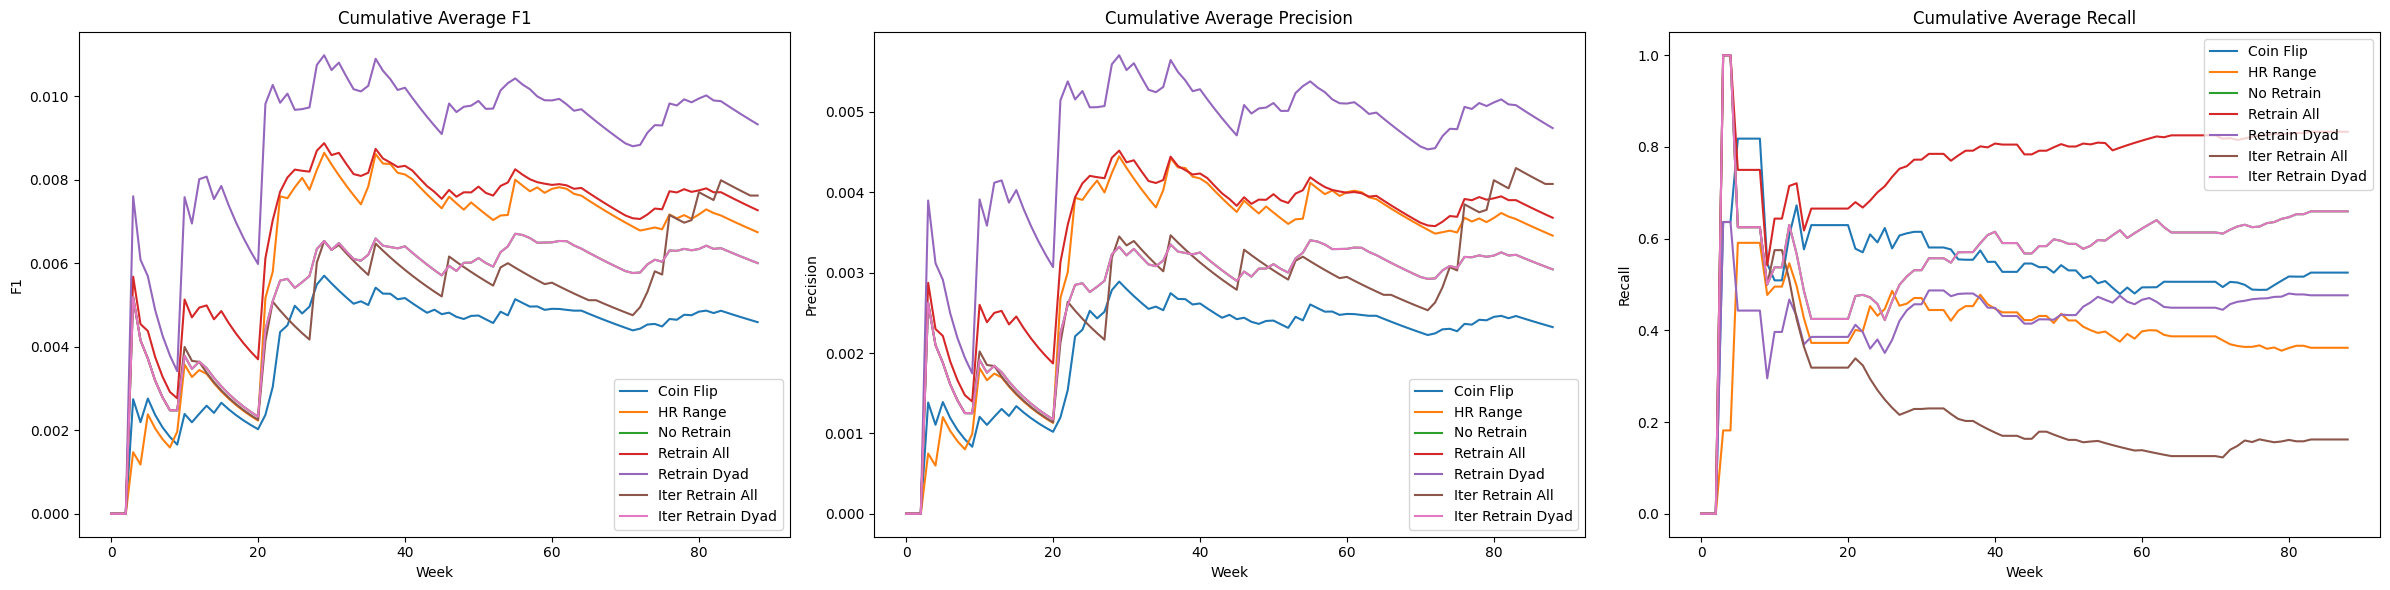

In [38]:
import matplotlib.pyplot as plt
import numpy as np


def cumulative_avg(metric_list):
    arr = np.array(metric_list, dtype=np.float64)
    cum_sum = np.nancumsum(arr)
    cum_count = np.cumsum(~np.isnan(arr))
    # cum_count = len(arr)
    return np.divide(
        cum_sum, cum_count, out=np.zeros_like(cum_sum), where=cum_count != 0
    )


def get_metric_by_week(results, metric):
    metric_vals = []
    weeks = []
    for result in results:
        weeks.append(result["week"])
        metric_vals.append(result[metric])
    return weeks, metric_vals


def prepare_cum_avg(results, metric):
    weeks, vals = get_metric_by_week(results, metric)
    cum_avg = cumulative_avg(vals)
    return weeks, cum_avg


metrics = ["f1", "precision", "recall"]
labels = [
    "Coin Flip",
    "HR Range",
    "No Retrain",
    "Retrain All",
    "Retrain Dyad",
    "Iter Retrain All",
    "Iter Retrain Dyad",
]
results_dicts = [
    coin_flip_model_results,
    hr_model_results,
    no_retrain_results,
    retrain_all_results,
    retrain_dyad_results,
    iter_retrain_all_results,
    iter_retrain_dyad_results,
]

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
for idx, metric in enumerate(metrics):
    for results_by_week, label in zip(results_dicts, labels):
        weeks, cum_avg = prepare_cum_avg(results_by_week, metric)
        axes[idx].plot(weeks, cum_avg, label=label)
    axes[idx].set_title(f"Cumulative Average {metric.capitalize()}")
    axes[idx].set_xlabel("Week")
    axes[idx].set_ylabel(metric.capitalize())
    axes[idx].legend()
plt.tight_layout()
plt.show()

DECIDED

-   recall is more important than precision -- if we achieve the same precision as pistachio 1.0 that's good enough

TODO

-   weekly performance, only show best model, weeks 0 to 20
-   run variations of prediction window (lookahead) + frequency, plot of sensitivity by frequency/lookahead
-   sensitivity + specificity + AUC+ROC
-   do weekly versions + trendline, not cum
-   for manuscript -- use terms e.g., "scheduled retraining", "closed loop"
-   why even do online learning -- capture "in situ" context, don't simply apply historical model to new cohort
-   experiment with oversampling recent data (or sample weighting, focus on the positive observations)
    -   look into regret minimization algos
